In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-09-27 11:12:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.8.16, 172.217.15.112, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.8.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.08s   

2020-09-27 11:12:39 (70.1 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [4]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [15]:
sentences[0]

"former versace store clerk sues over secret 'black code' for minority shoppers"

In [16]:
labels[0]

0

In [36]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [37]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [38]:
word_index = tokenizer.word_index

In [39]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [40]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [41]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [44]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.6563 - accuracy: 0.6096 - val_loss: 0.5511 - val_accuracy: 0.8107
Epoch 2/30
625/625 - 2s - loss: 0.4134 - accuracy: 0.8384 - val_loss: 0.3779 - val_accuracy: 0.8439
Epoch 3/30
625/625 - 2s - loss: 0.3045 - accuracy: 0.8785 - val_loss: 0.3511 - val_accuracy: 0.8514
Epoch 4/30
625/625 - 2s - loss: 0.2538 - accuracy: 0.9007 - val_loss: 0.3529 - val_accuracy: 0.8422
Epoch 5/30
625/625 - 2s - loss: 0.2189 - accuracy: 0.9158 - val_loss: 0.3448 - val_accuracy: 0.8568
Epoch 6/30
625/625 - 2s - loss: 0.1936 - accuracy: 0.9258 - val_loss: 0.3518 - val_accuracy: 0.8551
Epoch 7/30
625/625 - 2s - loss: 0.1709 - accuracy: 0.9365 - val_loss: 0.3661 - val_accuracy: 0.8520
Epoch 8/30
625/625 - 2s - loss: 0.1536 - accuracy: 0.9437 - val_loss: 0.3807 - val_accuracy: 0.8530
Epoch 9/30
625/625 - 2s - loss: 0.1375 - accuracy: 0.9513 - val_loss: 0.3979 - val_accuracy: 0.8523
Epoch 10/30
625/625 - 2s - loss: 0.1243 - accuracy: 0.9564 - val_loss: 0.4182 - val_accuracy: 0.8517

In [45]:
import matplotlib.pyplot as plt

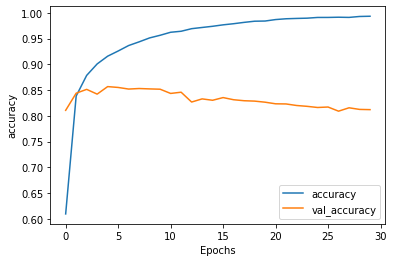

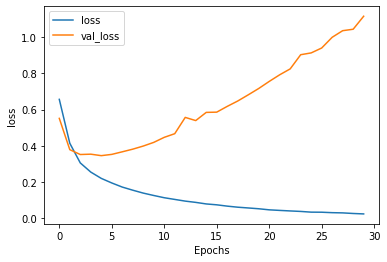

In [46]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')


In [47]:
reverse_word_index = dict([(value,key) for key,value in word_index.items()])

In [48]:
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [49]:
decode_sentence(training_padded[0])

"former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?"

In [52]:
training_sentences[2]

"mom starting to fear son's web series closest thing she will have to grandchild"

In [53]:
labels[2]

1

In [54]:
e = model.layers[0]
weights = e.get_weights()[0]
weights.shape

(10000, 16)

In [55]:
sentence = ['granny starting to fear spides in the garden might be real', 'game of thrones season finale showing this sunday night']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [58]:
padded

array([[   1,  890,    2,  891,    1,    5,    4, 2565,  380,   22,  178,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [ 249,    3,    1,  247, 3385, 2933,   20, 1551,  259,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [60]:
print(model.predict(padded))

[[8.337506e-01]
 [6.829881e-06]]
